In [1]:
import os, re, json, random, string, gc, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from wordcloud import WordCloud
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_recall_fscore_support, roc_auc_score)
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import RandomOverSampler

import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

plt.rcParams['figure.dpi'] = 140
sns.set(style="whitegrid")


In [2]:
# ================================
# 1) LOAD & CLEAN
# ================================
DATA_PATH = "Combined Data.csv"
df = pd.read_csv(DATA_PATH)

In [3]:
# Standardize columns
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

assert {'statement','status'}.issubset(df.columns), "Dataset must have 'statement' and 'status'."

In [4]:
# Drop NA/dupes and basic trimming
df['statement'] = df['statement'].astype(str).str.strip()
df = df.dropna(subset=['statement','status'])
df = df.drop_duplicates(subset=['statement', 'status']).reset_index(drop=True)

In [5]:
print("Dataset Shape (clean):", df.shape)
print("Labels:", df['status'].unique().tolist())

Dataset Shape (clean): (51099, 2)
Labels: ['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar', 'Personality disorder']


In [6]:
# ================================
# 2) LIGHT PREPROCESS (for TF-IDF & EDA)
# ================================
URL_RE = re.compile(r'(http|https)://\S+|www\.\S+')
MENTION_RE = re.compile(r'@\w+')
HASHTAG_RE = re.compile(r'#\w+')

def basic_clean(text: str) -> str:
    t = text.lower()
    t = URL_RE.sub(' ', t)
    t = MENTION_RE.sub(' ', t)
    t = HASHTAG_RE.sub(' ', t)
    t = re.sub(r'\d+', ' ', t)
    t = t.translate(str.maketrans('', '', string.punctuation))
    t = re.sub(r'\s+', ' ', t).strip()
    return t

df['clean_text'] = df['statement'].apply(basic_clean)
df['char_count'] = df['statement'].str.len()
df['word_count'] = df['statement'].apply(lambda x: len(str(x).split()))

In [7]:
# ================================
# 3) EXPLORATORY DATA ANALYSIS
# ================================
print("\nClass Distribution:\n", df['status'].value_counts())
print("\nChar Count Summary:\n", df['char_count'].describe())
print("\nWord Count Summary:\n", df['word_count'].describe())


Class Distribution:
 status
Normal                  16041
Depression              15094
Suicidal                10645
Anxiety                  3624
Bipolar                  2502
Stress                   2297
Personality disorder      896
Name: count, dtype: int64

Char Count Summary:
 count    51099.000000
mean       575.496076
std        847.899763
min          2.000000
25%         79.000000
50%        313.000000
75%        745.000000
max      32759.000000
Name: char_count, dtype: float64

Word Count Summary:
 count    51099.000000
mean       112.698292
std        164.115688
min          1.000000
25%         15.000000
50%         61.000000
75%        147.000000
max       6300.000000
Name: word_count, dtype: float64


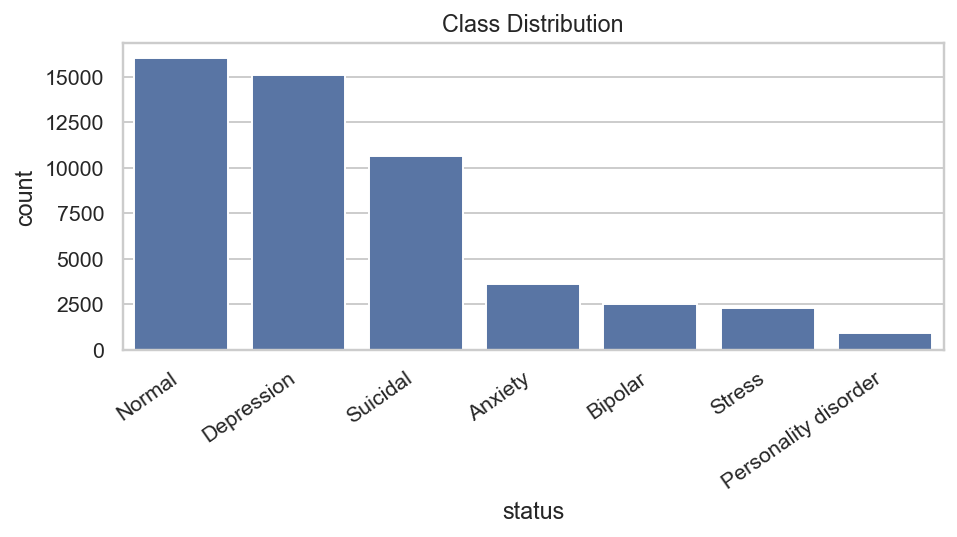

In [8]:
# Plot: Class distribution
plt.figure(figsize=(7,4))
order = df['status'].value_counts().index
sns.countplot(data=df, x='status', order=order)
plt.title('Class Distribution')
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.show()

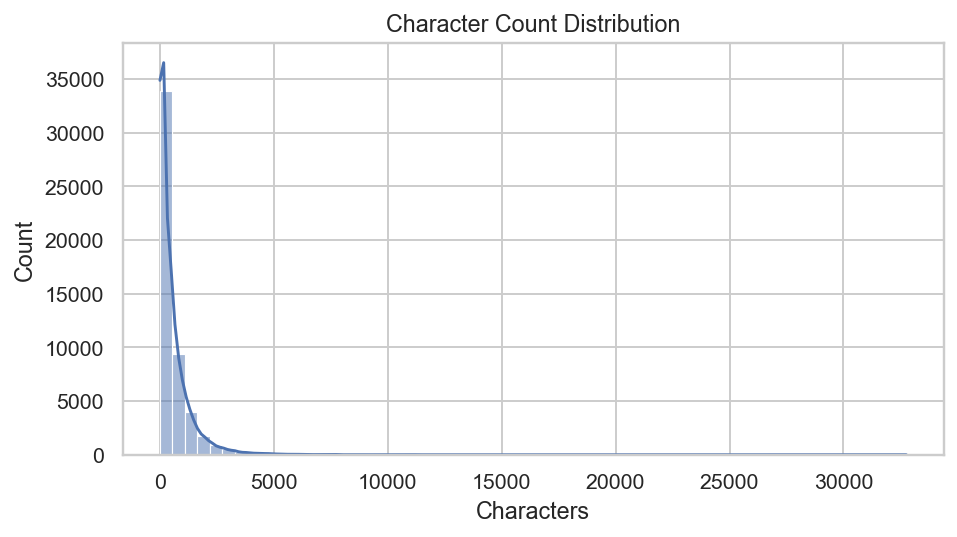

In [9]:
# Plot: Character length distribution
plt.figure(figsize=(7,4))
sns.histplot(df['char_count'], bins=60, kde=True)
plt.title('Character Count Distribution')
plt.xlabel('Characters')
plt.tight_layout()
plt.show()

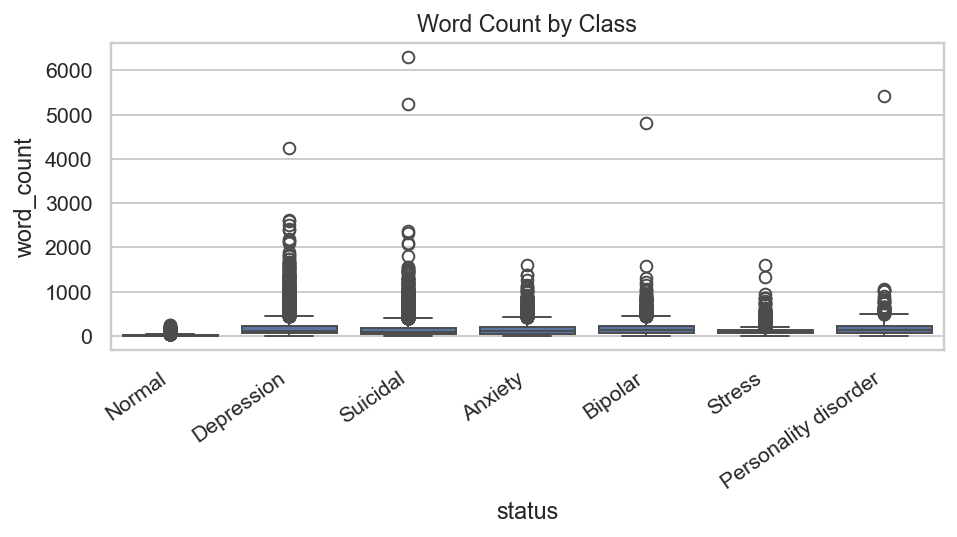

In [10]:
# Plot: Word count by class
plt.figure(figsize=(7,4))
sns.boxplot(data=df, x='status', y='word_count', order=order)
plt.title('Word Count by Class')
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.show()

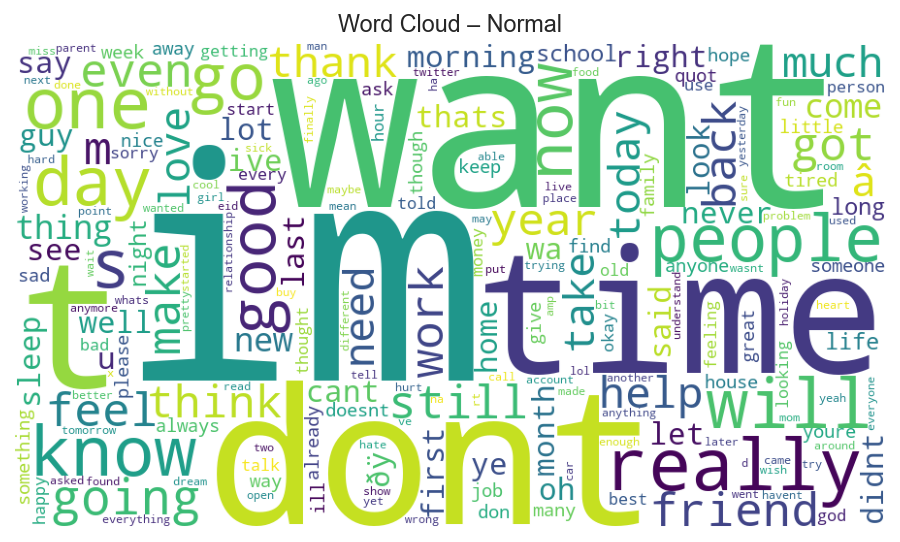

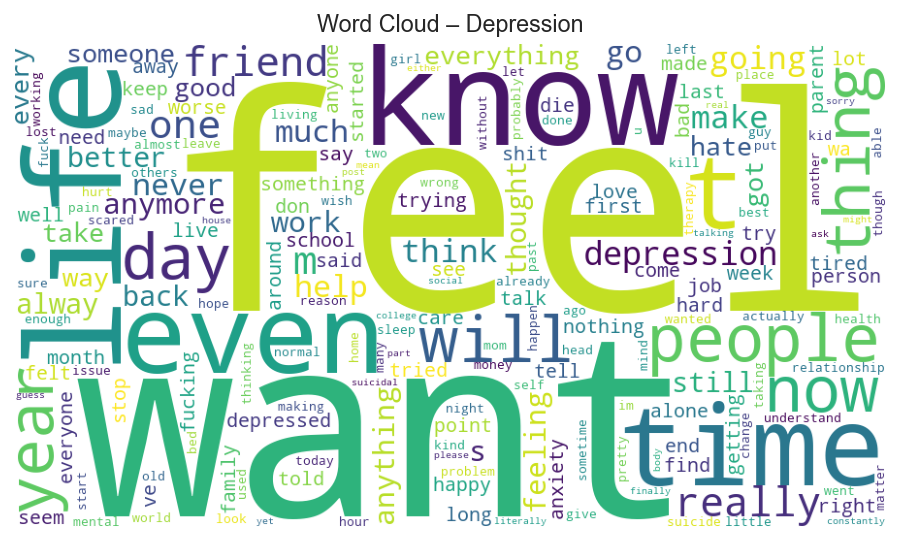

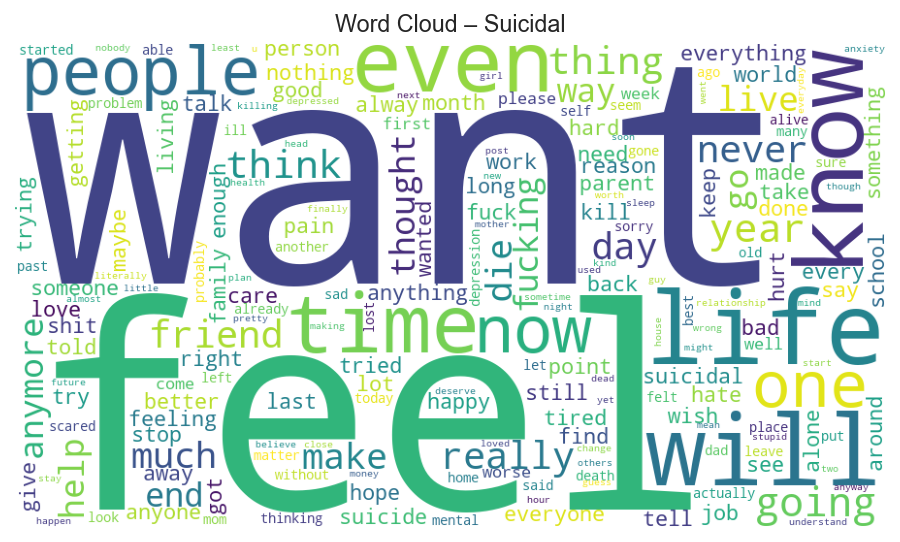

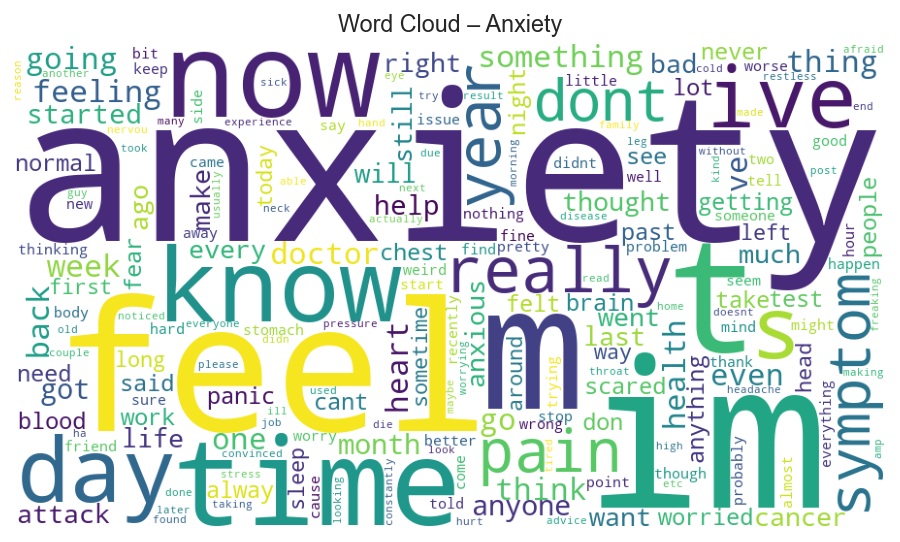

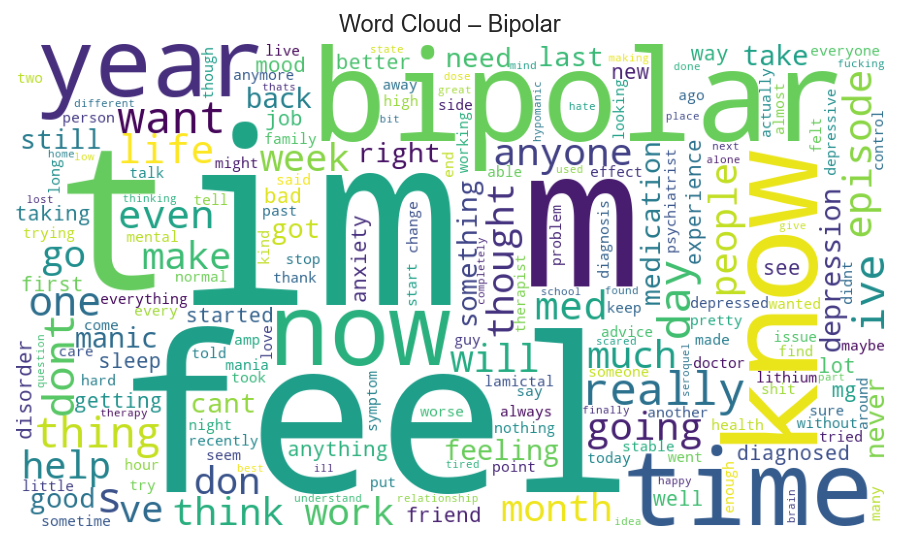

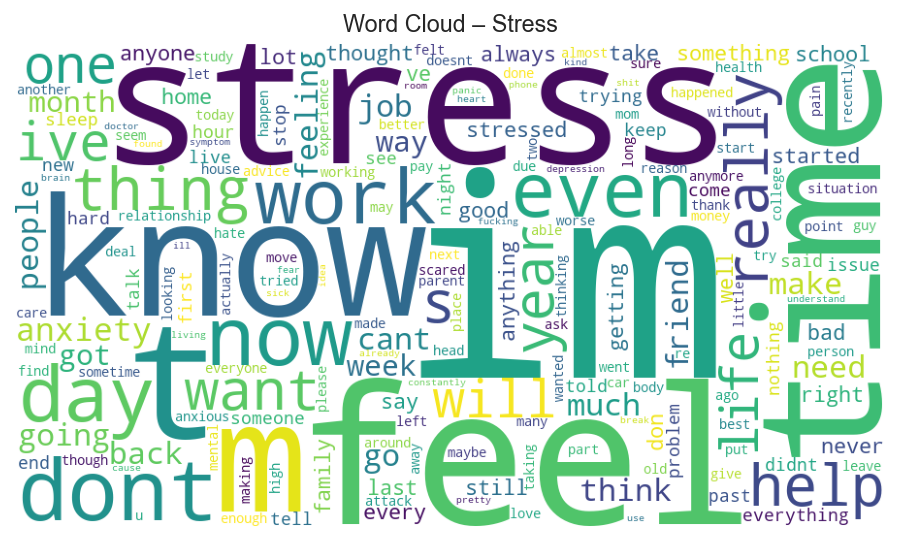

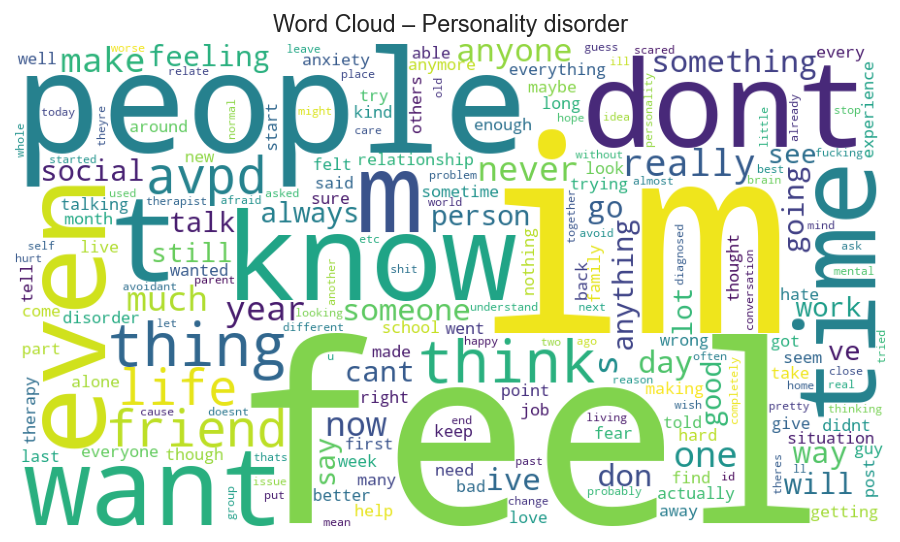

In [11]:
# WordClouds (optional; can be heavy on memory for very large classes)
for lab in order:
    text = " ".join(df.loc[df['status']==lab, 'clean_text'].sample(min(5000, df['status'].eq(lab).sum()), random_state=RNG_SEED))
    wc = WordCloud(width=900, height=500, background_color='white', collocations=False).generate(text)
    plt.figure(figsize=(7,4))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(f"Word Cloud – {lab}")
    plt.tight_layout()
    plt.show()

In [12]:
# ================================
# 4) TRAIN/VAL/TEST SPLIT (Stratified)
# ================================
lbl = LabelEncoder()
df['label'] = lbl.fit_transform(df['status'])  # mapping for all models

X_train, X_temp, y_train, y_temp = train_test_split(
    df['clean_text'], df['label'], test_size=0.3, random_state=RNG_SEED, stratify=df['label']
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RNG_SEED, stratify=y_temp
)

In [13]:
print(f"\nSplit sizes: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")
print("Label mapping:", dict(zip(lbl.classes_, lbl.transform(lbl.classes_))))


Split sizes: train=35769, val=7665, test=7665
Label mapping: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}


In [14]:
# Save mapping
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/label_mapping.json", "w") as f:
    json.dump({c:int(lbl.transform([c])[0]) for c in lbl.classes_}, f, indent=2)

In [15]:
# ================================
# 5) BASELINES (TF-IDF + Logistic/SVM)
#    – class imbalance: use class_weight='balanced' (and optional oversampling)
# ================================
def evaluate_model(name, y_true, y_pred, average='weighted', proba=None, labels=None):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=average, zero_division=0)
    print(f"\n[{name}] Accuracy={acc:.4f} | Precision={p:.4f} | Recall={r:.4f} | F1={f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=lbl.classes_))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=lbl.classes_, yticklabels=lbl.classes_)
    plt.title(f'Confusion Matrix – {name}')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout(); plt.show()
    return acc, p, r, f1


[TF-IDF + LogisticRegression (val)] Accuracy=0.7682 | Precision=0.7765 | Recall=0.7682 | F1=0.7683
                      precision    recall  f1-score   support

             Anxiety       0.76      0.81      0.79       543
             Bipolar       0.72      0.78      0.75       376
          Depression       0.80      0.64      0.71      2264
              Normal       0.89      0.92      0.90      2406
Personality disorder       0.54      0.60      0.57       134
              Stress       0.49      0.70      0.58       345
            Suicidal       0.68      0.74      0.71      1597

            accuracy                           0.77      7665
           macro avg       0.70      0.74      0.71      7665
        weighted avg       0.78      0.77      0.77      7665



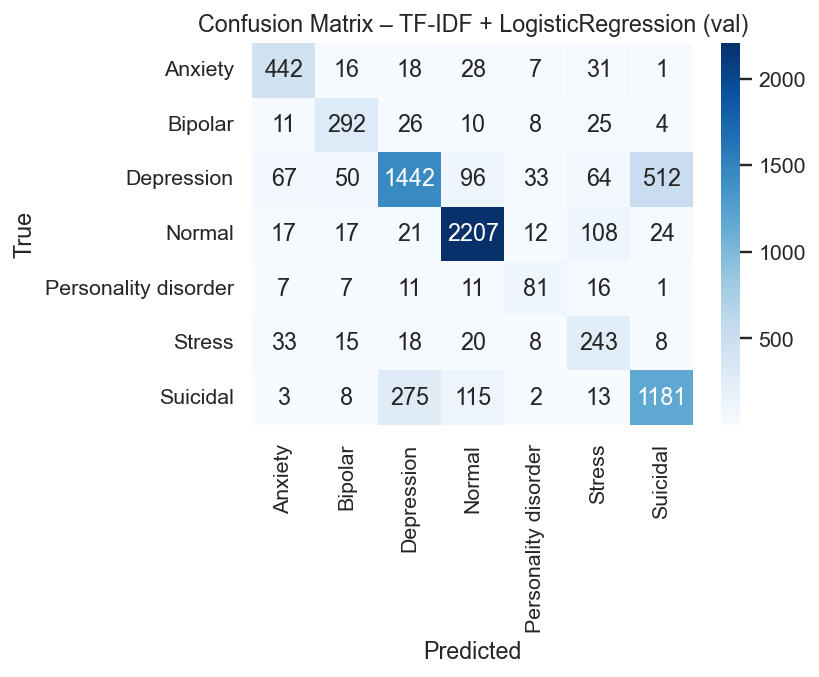

In [16]:
# Vectorizer
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    min_df=2,
    sublinear_tf=True
)

# Logistic Regression baseline (probabilities available)
logit = LogisticRegression(
    max_iter=3000,
    class_weight='balanced',
    n_jobs=-1
)

logit_pipe = Pipeline([
    ('tfidf', tfidf),
    ('clf', logit)
])

logit_pipe.fit(X_train, y_train)
y_val_pred_logit = logit_pipe.predict(X_val)
acc_lg, p_lg, r_lg, f1_lg = evaluate_model("TF-IDF + LogisticRegression (val)", y_val, y_val_pred_logit, labels=np.arange(len(lbl.classes_)))


[TF-IDF + LinearSVM (val)] Accuracy=0.7823 | Precision=0.7792 | Recall=0.7823 | F1=0.7780
                      precision    recall  f1-score   support

             Anxiety       0.83      0.79      0.81       543
             Bipolar       0.84      0.70      0.76       376
          Depression       0.72      0.75      0.73      2264
              Normal       0.88      0.96      0.92      2406
Personality disorder       0.80      0.45      0.57       134
              Stress       0.69      0.47      0.56       345
            Suicidal       0.70      0.68      0.69      1597

            accuracy                           0.78      7665
           macro avg       0.78      0.69      0.72      7665
        weighted avg       0.78      0.78      0.78      7665



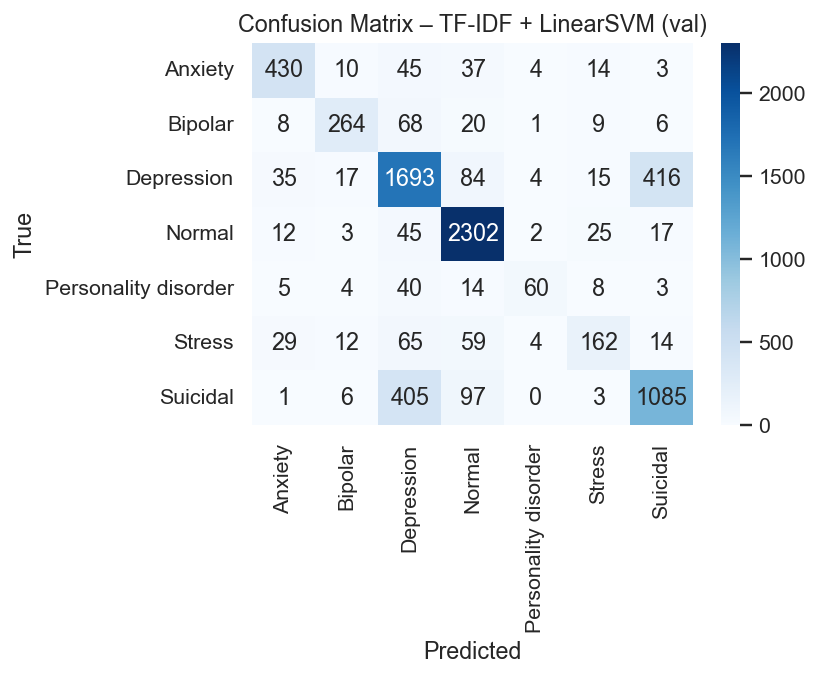

In [17]:
# Linear SVM (use calibration to get probabilities for ROC-AUC if needed)
svm = LinearSVC(class_weight='balanced')
svm_cal = CalibratedClassifierCV(svm, cv=3)  # adds predict_proba
svm_pipe = Pipeline([
    ('tfidf', tfidf),
    ('clf', svm_cal)
])
svm_pipe.fit(X_train, y_train)
y_val_pred_svm = svm_pipe.predict(X_val)
acc_svm, p_svm, r_svm, f1_svm = evaluate_model("TF-IDF + LinearSVM (val)", y_val, y_val_pred_svm, labels=np.arange(len(lbl.classes_)))

In [18]:
# Pick best baseline on val
best_baseline_name = "logit" if f1_lg >= f1_svm else "svm"
best_baseline = logit_pipe if best_baseline_name == "logit" else svm_pipe
print(f"\nBest baseline by F1 on val: {best_baseline_name.upper()}")


Best baseline by F1 on val: SVM



[Best Baseline (SVM) – TEST] Accuracy=0.7843 | Precision=0.7816 | Recall=0.7843 | F1=0.7806
                      precision    recall  f1-score   support

             Anxiety       0.83      0.79      0.81       544
             Bipolar       0.83      0.71      0.77       375
          Depression       0.72      0.74      0.73      2264
              Normal       0.89      0.96      0.92      2406
Personality disorder       0.79      0.53      0.64       135
              Stress       0.70      0.45      0.55       344
            Suicidal       0.70      0.70      0.70      1597

            accuracy                           0.78      7665
           macro avg       0.78      0.70      0.73      7665
        weighted avg       0.78      0.78      0.78      7665



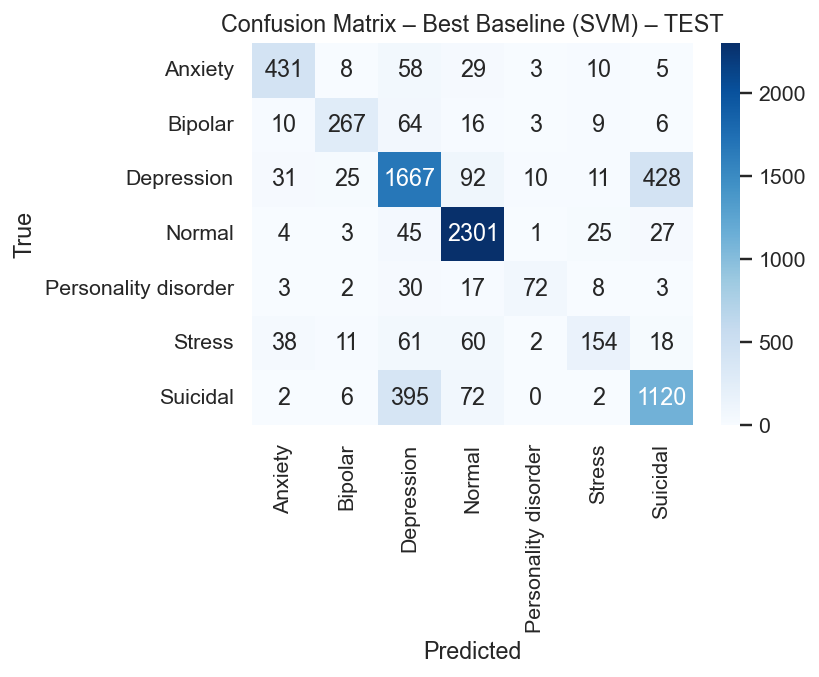

Saved: artifacts/baseline_tfidf_model.joblib


In [19]:
# Test evaluation for best baseline
y_test_pred_bl = best_baseline.predict(X_test)
_ = evaluate_model(f"Best Baseline ({best_baseline_name.upper()}) – TEST", y_test, y_test_pred_bl, labels=np.arange(len(lbl.classes_)))

joblib.dump(best_baseline, "artifacts/baseline_tfidf_model.joblib")
print("Saved: artifacts/baseline_tfidf_model.joblib")

In [20]:
# ================================
# 6) LSTM (PyTorch) – Simple tokenizer, learned embeddings
# ================================
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [21]:
# Build a simple wordpiece-ish tokenizer (space-split) and vocab
def build_vocab(texts, min_freq=2, max_size=50000):
    freq = {}
    for t in texts:
        for w in t.split():
            freq[w] = freq.get(w, 0) + 1
    # sort by frequency
    items = sorted([(w,c) for w,c in freq.items() if c>=min_freq], key=lambda x: -x[1])
    if max_size:
        items = items[:max_size]
    stoi = {"<pad>":0, "<unk>":1}
    for w,_ in items:
        if w not in stoi:
            stoi[w] = len(stoi)
    itos = {i:w for w,i in stoi.items()}
    return stoi, itos

stoi, itos = build_vocab(pd.concat([X_train, X_val]))
vocab_size = len(stoi)
print("Vocab size:", vocab_size)

Vocab size: 28465


In [22]:
def encode(text, max_len=128):
    ids = [stoi.get(w, 1) for w in text.split()]
    if len(ids) < max_len:
        ids = ids + [0]*(max_len - len(ids))
    else:
        ids = ids[:max_len]
    return np.array(ids, dtype=np.int64)

class TxtDS(Dataset):
    def __init__(self, texts, labels, max_len=128):
        self.X = [encode(t, max_len) for t in texts]
        self.y = np.array(labels, dtype=np.int64)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): 
        return torch.tensor(self.X[i]), torch.tensor(self.y[i])

In [23]:
MAX_LEN = 128
BATCH = 64
NCLASS = len(lbl.classes_)

In [24]:
train_ds = TxtDS(X_train.tolist(), y_train.tolist(), MAX_LEN)
val_ds   = TxtDS(X_val.tolist(), y_val.tolist(), MAX_LEN)
test_ds  = TxtDS(X_test.tolist(), y_test.tolist(), MAX_LEN)

In [25]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH)
test_dl  = DataLoader(test_ds, batch_size=BATCH)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden=128, num_class=NCLASS, pad_idx=0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden*2, num_class)
    def forward(self, x):
        e = self.emb(x)               # (B,L,E)
        o, _ = self.lstm(e)           # (B,L,2H)
        h = o[:, -1, :]               # last timestep
        h = self.dropout(h)
        return self.fc(h)

model = LSTMClassifier(vocab_size=vocab_size).to(device)
criterion = nn.CrossEntropyLoss()  # could add class weights if needed
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)

In [28]:
def run_epoch(dl, train=True):
    model.train(train)
    total_loss=0; preds=[]; trues=[]
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        with torch.set_grad_enabled(train):
            out = model(xb)
            loss = criterion(out, yb)
            if train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()*xb.size(0)
        preds.extend(out.argmax(1).detach().cpu().numpy())
        trues.extend(yb.detach().cpu().numpy())
    avg_loss = total_loss/len(dl.dataset)
    acc = accuracy_score(trues, preds)
    return avg_loss, acc, np.array(trues), np.array(preds)

EPOCHS = 5
best_val_acc = 0.0
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc, _, _ = run_epoch(train_dl, train=True)
    va_loss, va_acc, yv, pv = run_epoch(val_dl, train=False)
    print(f"Epoch {ep}: train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={va_loss:.4f} acc={va_acc:.4f}")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), "artifacts/lstm_best.pt")

Epoch 1: train_loss=1.3143 acc=0.4979 | val_loss=0.9897 acc=0.5821
Epoch 2: train_loss=0.9415 acc=0.6010 | val_loss=0.8574 acc=0.6311
Epoch 3: train_loss=0.7828 acc=0.6704 | val_loss=0.7805 acc=0.6806
Epoch 4: train_loss=0.6558 acc=0.7392 | val_loss=0.7431 acc=0.7033
Epoch 5: train_loss=0.5498 acc=0.7886 | val_loss=0.7448 acc=0.7104



LSTM – TEST
                      precision    recall  f1-score   support

             Anxiety       0.65      0.77      0.71       544
             Bipolar       0.62      0.45      0.52       375
          Depression       0.76      0.54      0.63      2264
              Normal       0.90      0.93      0.91      2406
Personality disorder       0.33      0.10      0.15       135
              Stress       0.34      0.50      0.41       344
            Suicidal       0.59      0.77      0.67      1597

            accuracy                           0.71      7665
           macro avg       0.60      0.58      0.57      7665
        weighted avg       0.72      0.71      0.71      7665



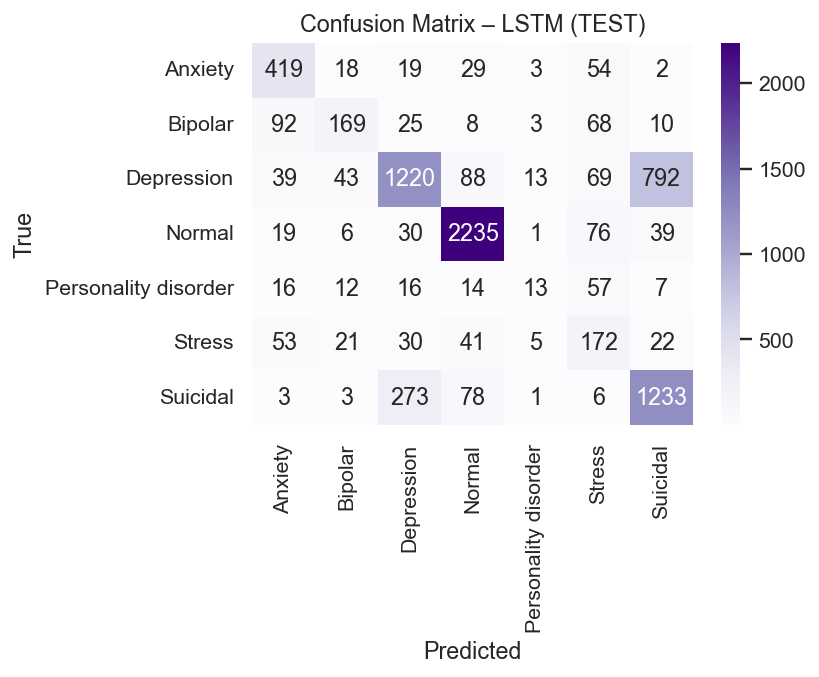

In [29]:
# Evaluate on test
model.load_state_dict(torch.load("artifacts/lstm_best.pt", map_location=device))
_, _, yt, pt = run_epoch(test_dl, train=False)
print("\nLSTM – TEST")
print(classification_report(yt, pt, target_names=lbl.classes_))
cm = confusion_matrix(yt, pt)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=lbl.classes_, yticklabels=lbl.classes_)
plt.title('Confusion Matrix – LSTM (TEST)')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()

Map:   0%|          | 0/35769 [00:00<?, ? examples/s]

Map:   0%|          | 0/7665 [00:00<?, ? examples/s]

Map:   0%|          | 0/7665 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\Jupyter\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 1.8559, 'grad_norm': 10.136006355285645, 'learning_rate': 1.9853905784138342e-05, 'epoch': 0.022361359570661897}
{'loss': 1.569, 'grad_norm': 9.732139587402344, 'learning_rate': 1.9704830053667266e-05, 'epoch': 0.044722719141323794}
{'loss': 1.3518, 'grad_norm': 9.223633766174316, 'learning_rate': 1.9555754323196186e-05, 'epoch': 0.06708407871198568}
{'loss': 1.2498, 'grad_norm': 9.48072624206543, 'learning_rate': 1.9406678592725106e-05, 'epoch': 0.08944543828264759}
{'loss': 1.0249, 'grad_norm': 8.398032188415527, 'learning_rate': 1.9257602862254027e-05, 'epoch': 0.11180679785330948}
{'loss': 0.9235, 'grad_norm': 10.227118492126465, 'learning_rate': 1.9108527131782947e-05, 'epoch': 0.13416815742397137}
{'loss': 0.885, 'grad_norm': 5.777981758117676, 'learning_rate': 1.8959451401311867e-05, 'epoch': 0.15652951699463327}
{'loss': 0.8782, 'grad_norm': 13.491721153259277, 'learning_rate': 1.8810375670840787e-05, 'epoch': 0.17889087656529518}
{'loss': 0.7822, 'grad_norm': 8.526765

D:\Jupyter\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 0.556, 'grad_norm': 3.9455623626708984, 'learning_rate': 1.3294573643410852e-05, 'epoch': 1.0062611806797854}
{'loss': 0.4712, 'grad_norm': 25.4948787689209, 'learning_rate': 1.3145497912939776e-05, 'epoch': 1.0286225402504472}
{'loss': 0.4718, 'grad_norm': 11.73508358001709, 'learning_rate': 1.2996422182468695e-05, 'epoch': 1.0509838998211092}
{'loss': 0.3703, 'grad_norm': 4.551438808441162, 'learning_rate': 1.2847346451997615e-05, 'epoch': 1.073345259391771}
{'loss': 0.4207, 'grad_norm': 23.57203483581543, 'learning_rate': 1.2698270721526535e-05, 'epoch': 1.095706618962433}
{'loss': 0.5218, 'grad_norm': 27.794353485107422, 'learning_rate': 1.2549194991055457e-05, 'epoch': 1.118067978533095}
{'loss': 0.4801, 'grad_norm': 2.6712865829467773, 'learning_rate': 1.2400119260584377e-05, 'epoch': 1.1404293381037567}
{'loss': 0.4025, 'grad_norm': 2.7048115730285645, 'learning_rate': 1.2251043530113298e-05, 'epoch': 1.1627906976744187}
{'loss': 0.4965, 'grad_norm': 7.16426420211792, '

D:\Jupyter\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 0.3257, 'grad_norm': 2.6976616382598877, 'learning_rate': 6.586165772212284e-06, 'epoch': 2.012522361359571}
{'loss': 0.2974, 'grad_norm': 3.217773914337158, 'learning_rate': 6.437090041741205e-06, 'epoch': 2.0348837209302326}
{'loss': 0.2782, 'grad_norm': 3.881228446960449, 'learning_rate': 6.288014311270125e-06, 'epoch': 2.0572450805008944}
{'loss': 0.404, 'grad_norm': 4.264988899230957, 'learning_rate': 6.138938580799046e-06, 'epoch': 2.079606440071556}
{'loss': 0.2562, 'grad_norm': 2.6423561573028564, 'learning_rate': 5.989862850327967e-06, 'epoch': 2.1019677996422184}
{'loss': 0.3011, 'grad_norm': 2.353243112564087, 'learning_rate': 5.840787119856888e-06, 'epoch': 2.12432915921288}
{'loss': 0.2593, 'grad_norm': 17.839956283569336, 'learning_rate': 5.691711389385809e-06, 'epoch': 2.146690518783542}
{'loss': 0.235, 'grad_norm': 5.445430755615234, 'learning_rate': 5.542635658914729e-06, 'epoch': 2.169051878354204}
{'loss': 0.2964, 'grad_norm': 4.736549377441406, 'learning_ra

D:\Jupyter\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.6736279726028442, 'eval_accuracy': 0.8203522504892368, 'eval_precision': 0.8246832944603623, 'eval_recall': 0.8203522504892368, 'eval_f1': 0.8205948979827659, 'eval_runtime': 827.3243, 'eval_samples_per_second': 9.265, 'eval_steps_per_second': 0.58, 'epoch': 3.0}

BERT – VAL metrics: {'eval_loss': 0.6736279726028442, 'eval_accuracy': 0.8203522504892368, 'eval_precision': 0.8246832944603623, 'eval_recall': 0.8203522504892368, 'eval_f1': 0.8205948979827659, 'eval_runtime': 827.3243, 'eval_samples_per_second': 9.265, 'eval_steps_per_second': 0.58, 'epoch': 3.0}


D:\Jupyter\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



BERT – TEST (weighted metrics)
                      precision    recall  f1-score   support

             Anxiety       0.87      0.90      0.88       544
             Bipolar       0.82      0.84      0.83       375
          Depression       0.81      0.71      0.76      2264
              Normal       0.96      0.95      0.95      2406
Personality disorder       0.70      0.70      0.70       135
              Stress       0.65      0.79      0.71       344
            Suicidal       0.69      0.78      0.73      1597

            accuracy                           0.82      7665
           macro avg       0.79      0.81      0.80      7665
        weighted avg       0.83      0.82      0.82      7665



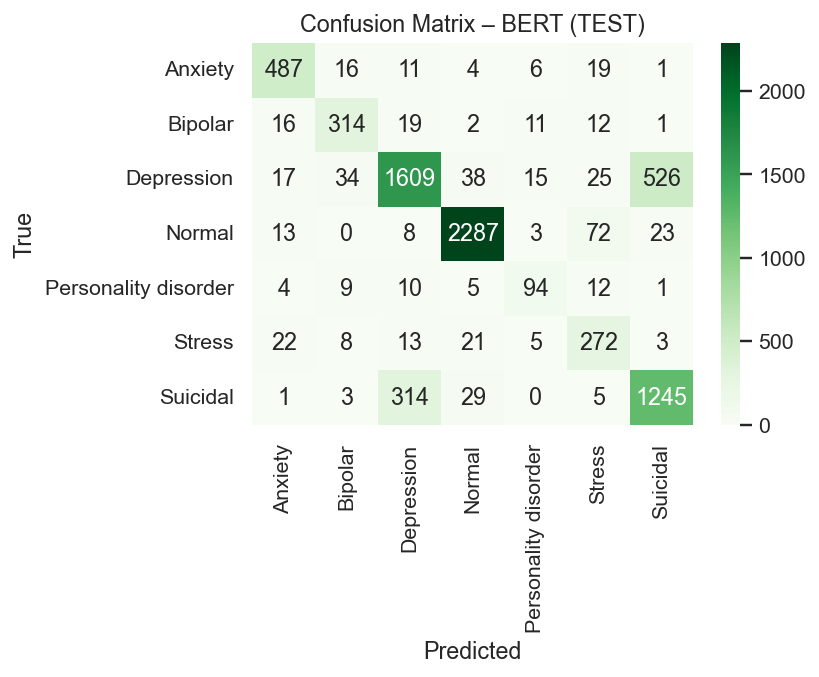

In [32]:
# ================================
# BERT TRAINING — Transformers 4.55 friendly
# ================================
import os, numpy as np, torch, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset as HFDataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

os.environ["WANDB_DISABLED"] = "true"

BERT_MODEL = "bert-base-uncased"
SEED = RNG_SEED
MAX_LEN = 128
BATCH = 16
EPOCHS = 3
LR = 2e-5

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=True)

def tok_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

# HF datasets
train_hf = HFDataset.from_pandas(pd.DataFrame({"text": X_train, "label": y_train}))
val_hf   = HFDataset.from_pandas(pd.DataFrame({"text": X_val,   "label": y_val}))
test_hf  = HFDataset.from_pandas(pd.DataFrame({"text": X_test,  "label": y_test}))

train_hf = train_hf.map(tok_fn, batched=True)
val_hf   = val_hf.map(tok_fn, batched=True)
test_hf  = test_hf.map(tok_fn, batched=True)

KEEP = ["input_ids","attention_mask","label"]
train_hf = train_hf.remove_columns([c for c in train_hf.column_names if c not in KEEP])
val_hf   = val_hf.remove_columns([c for c in val_hf.column_names if c not in KEEP])
test_hf  = test_hf.remove_columns([c for c in test_hf.column_names if c not in KEEP])

train_hf.set_format("torch"); val_hf.set_format("torch"); test_hf.set_format("torch")

# Model
bert = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=NCLASS)

# Class weights
cw = compute_class_weight(class_weight="balanced", classes=np.arange(NCLASS), y=y_train)
class_weights = torch.tensor(cw, dtype=torch.float)

# Custom Trainer: accept **kwargs to handle num_items_in_batch (4.55+)
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.get("logits")
        w = self.class_weights.to(logits.device) if self.class_weights is not None else None
        loss_fct = torch.nn.CrossEntropyLoss(weight=w)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

# TrainingArguments — now safe to match save/eval strategies
# Minimal, version-proof TrainingArguments (no eval/save strategies)
args = TrainingArguments(
    output_dir="artifacts/bert_out",
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    weight_decay=0.01,
    logging_steps=50,
    disable_tqdm=True,      # avoids widget issues
    report_to="none",
    seed=SEED,
    dataloader_num_workers=0
)


# Dynamic padding collator (works fine)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    model=bert,
    args=args,
    train_dataset=train_hf,
    eval_dataset=val_hf,
    processing_class=tokenizer,     # <- replaces deprecated tokenizer=
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

# Train + evaluate
# then:
train_result = trainer.train()
val_metrics = trainer.evaluate(val_hf)
print("\nBERT – VAL metrics:", val_metrics)

trainer.save_model("artifacts/bert_model")
tokenizer.save_pretrained("artifacts/bert_model")

pred = trainer.predict(test_hf)
y_pred_bert = np.argmax(pred.predictions, axis=1)
print("\nBERT – TEST (weighted metrics)")
print(classification_report(y_test, y_pred_bert, target_names=lbl.classes_))

cm = confusion_matrix(y_test, y_pred_bert)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=lbl.classes_, yticklabels=lbl.classes_)
plt.title('Confusion Matrix – BERT (TEST)')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()

In [36]:
# =========================================
#  ERROR ANALYSIS + EXPORT PREDICTIONS
# =========================================
import torch, numpy as np, pandas as pd
from scipy.special import softmax

In [38]:
# Collect probs and predictions for TEST
test_pred = trainer.predict(test_hf)
logits = test_pred.predictions
probs = softmax(logits, axis=1)
y_pred = probs.argmax(axis=1)

D:\Jupyter\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [39]:
#  Align texts with predictions (ensure same order as test_hf was built)
X_test_series = pd.Series(X_test).reset_index(drop=True)
y_test_series = pd.Series(y_test).reset_index(drop=True)

pred_df = pd.DataFrame({
    "text": X_test_series,
    "true_id": y_test_series,
    "pred_id": y_pred,
    "true_label": lbl.inverse_transform(y_test_series),
    "pred_label": lbl.inverse_transform(y_pred),
    "pred_confidence": probs.max(axis=1).round(4)
})

In [40]:
#  Misclassifications
errors_df = pred_df[pred_df["true_id"] != pred_df["pred_id"]].copy()
print(f"\nMisclassified samples: {len(errors_df)} / {len(pred_df)}")
errors_df.head(10)


Misclassified samples: 1357 / 7665


,text,true_id,pred_id,true_label,pred_label,pred_confidence
10,when people tell you they will always be there...,6,2,Suicidal,Depression,0.8018
11,my mind frame is so low i feel like i just do ...,2,6,Depression,Suicidal,0.8258
13,i just wanted to thank everyone on this sub re...,3,5,Normal,Stress,0.9590
14,i grew up in a town that was huge on high scho...,2,3,Depression,Normal,0.6278
15,i do not really have anyone in my life that i ...,6,2,Suicidal,Depression,0.7328
16,i have abandoned all people i called friends i...,2,6,Depression,Suicidal,0.8103
18,i have failed so much throughout my life and i...,2,6,Depression,Suicidal,0.6138
19,so i decided that i am going to talk to my doc...,3,5,Normal,Stress,0.6453
20,it is really bad seeing how many people strugg...,2,6,Depression,Suicidal,0.7349
27,looking for friend just looking for a friend w...,1,2,Bipolar,Depression,0.8855


In [41]:
#  Save full predictions and errors
import os
os.makedirs("artifacts", exist_ok=True)
pred_df.to_csv("artifacts/bert_test_predictions.csv", index=False)
errors_df.to_csv("artifacts/bert_test_misclassified.csv", index=False)
print("Saved predictions to artifacts/bert_test_predictions.csv")
print("Saved misclassifications to artifacts/bert_test_misclassified.csv")

Saved predictions to artifacts/bert_test_predictions.csv
Saved misclassifications to artifacts/bert_test_misclassified.csv


In [42]:
#  Show top-5 most confident wrong predictions
top_wrong = errors_df.sort_values("pred_confidence", ascending=False).head(5)
print("\nTop-5 confident misclassifications:\n")
for i, row in top_wrong.iterrows():
    print(f"[conf={row.pred_confidence:.3f}] TRUE={row.true_label} | PRED={row.pred_label}")
    print(row.text[:300].replace("\n"," "))
    print("-"*80)


Top-5 confident misclassifications:

[conf=0.998] TRUE=Depression | PRED=Anxiety
who have these symptom i have it for month but im still anxious and scared
--------------------------------------------------------------------------------
[conf=0.998] TRUE=Depression | PRED=Bipolar
faster medicine response in bipolar my doctor said that in bipolar patients they sometimes have much faster reaction times to new medicine does anyone have any literature explaining this
--------------------------------------------------------------------------------
[conf=0.998] TRUE=Depression | PRED=Anxiety
can anxiety because confusion confused intrusive thoughts i am afraid of dementia i have chronic anxiety panic hipochondriac etc anxiety and confusion
--------------------------------------------------------------------------------
[conf=0.998] TRUE=Personality disorder | PRED=Anxiety
any hypochondriacs here except for me like i think about suicide all of the time but had hiv scare and now think i will 

In [55]:
# ================================
# LIME EXPLANATIONS — memory-safe
# ================================
from lime.lime_text import LimeTextExplainer
import numpy as np
import torch

class_names = list(lbl.classes_)
bert_model = trainer.model.eval()
tokenizer_ = tokenizer  # already loaded

# 1) Batched predict_proba to avoid huge tensors in memory
def bert_predict_proba_batched(texts, batch_size=8, max_length=128):
    out = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer_(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
        with torch.no_grad():
            logits = bert_model(**{k: v for k, v in enc.items()}).logits
            p = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
        out.append(p)
        # free ASAP
        del enc, logits
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    return np.vstack(out)

explainer = LimeTextExplainer(class_names=class_names)

# Helper: shorten long texts for explanation (LIME works fine on a snippet)
def clip_words(text, max_words=80):
    toks = text.split()
    if len(toks) <= max_words:
        return text
    return " ".join(toks[:max_words])

# Pick a few examples (balanced: 1 correct + 1 wrong per class, up to 6–8 total)
examples = []
for cid, cname in enumerate(class_names):
    correct_rows = pred_df[(pred_df.true_id==cid) & (pred_df.pred_id==cid)]
    wrong_rows   = pred_df[(pred_df.true_id==cid) & (pred_df.pred_id!=cid)]
    if len(correct_rows) > 0:
        examples.append(("CORRECT", cname, correct_rows.sample(1, random_state=RNG_SEED).iloc[0]))
    if len(wrong_rows) > 0:
        examples.append(("WRONG",   cname, wrong_rows.sample(1, random_state=RNG_SEED).iloc[0]))
    if len(examples) >= 8:
        break

print("\n--- LIME Explanations (memory-safe) ---")
for tag, cname, row in examples:
    txt = clip_words(row["text"], max_words=80)  # <= truncate aggressively
    try:
        exp = explainer.explain_instance(
            txt,
            classifier_fn=lambda x: bert_predict_proba_batched(x, batch_size=8, max_length=128),
            num_features=8,          # smaller feature set
            num_samples=600,         # << reduce from 5000 to keep RAM low
            labels=[row["pred_id"]]  # explain predicted class
        )
        print(f"\n[{tag}] true={row['true_label']} pred={row['pred_label']} conf={row['pred_confidence']:.3f}")
        print(txt[:300].replace("\n"," "))
        weights = exp.as_list(label=row["pred_id"])
        print("Top tokens driving prediction:")
        for w, s in weights[:8]:
            print(f"  {w:>20s}  {s:+.3f}")
    except RuntimeError as e:
        print(f"(skipped one example due to memory/runtime: {e})")
        continue



--- LIME Explanations (memory-safe) ---

[CORRECT] true=Anxiety pred=Anxiety conf=0.998
testicular cancer about a year ago i noticed a lump on top of my testicle two urologist vists later i was told hes sure its appendicitis of the teste because theres no blood flow it the lump my concern is that its cancer because that testicle is larger and thicker then my other and it occasionally b
Top tokens driving prediction:
                cancer  +0.110
            testicular  +0.080
                    im  +0.078
                 teste  +0.048
               concern  +0.045
              testicle  +0.041
                theres  +0.039
                 later  -0.014

[WRONG] true=Anxiety pred=Stress conf=0.803
i’ve recently been having problems with heart palpitations and increased anxious feelings hi reddit i am a young adult female in her first year of university and i just wanted some reassurance or advice i’ve grown up around anxious people having parents and step parents on anti depress

In [56]:
# =========================================
#  EARLY DISTRESS DETECTION (roll-up metric)
#    Collapse classes into: Distress vs Normal
#    Distress = {Depression, Suicidal, Anxiety, Bipolar, Stress, Personality disorder}
# =========================================
distress_set = set([lab for lab in class_names if lab.lower() != "normal"])

true_distress = y_test_series.apply(lambda i: 1 if lbl.classes_[i] in distress_set else 0).values
pred_distress = np.array([1 if class_names[j] in distress_set else 0 for j in y_pred])

In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [58]:
p_bin = precision_score(true_distress, pred_distress, zero_division=0)
r_bin = recall_score(true_distress, pred_distress, zero_division=0)
f1_bin = f1_score(true_distress, pred_distress, zero_division=0)
cm_bin = confusion_matrix(true_distress, pred_distress, labels=[0,1])

In [59]:
print("\n=== Early Distress Detection (Binary) ===")
print(f"Precision: {p_bin:.3f} | Recall: {r_bin:.3f} | F1: {f1_bin:.3f}")
print("Confusion Matrix [rows=true, cols=pred]:\n", cm_bin)


=== Early Distress Detection (Binary) ===
Precision: 0.977 | Recall: 0.981 | F1: 0.979
Confusion Matrix [rows=true, cols=pred]:
 [[2287  119]
 [  99 5160]]


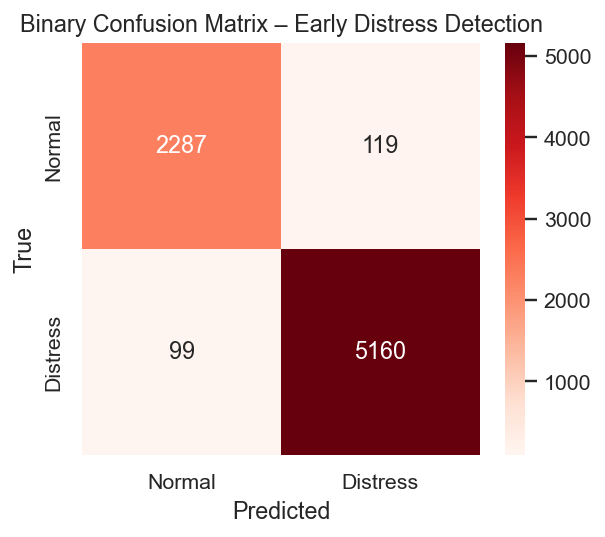

In [60]:
# Plot binary confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(4.5,4))
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Normal','Distress'], yticklabels=['Normal','Distress'])
plt.title('Binary Confusion Matrix – Early Distress Detection')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()

In [67]:
# =========================================
# 13) SIMPLE INFERENCE UTILITIES + SAVE ARTIFACTS
# =========================================
def bert_predict_texts(texts, return_proba=False):
    enc = tokenizer_(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
    with torch.no_grad():
        out = bert_model(**{k:v for k,v in enc.items()})
        p = torch.nn.functional.softmax(out.logits, dim=1).cpu().numpy()
        ids = p.argmax(axis=1)
        labels = lbl.inverse_transform(ids)
    if return_proba:
        return labels, p
    return labels

In [69]:
# Demo
sample_posts = [
    "I can't focus, haven't slept in days and my chest feels tight.",
    "Had a great workout and dinner with friends; feeling calm."
]
print("\nSample inference:", bert_predict_texts(sample_posts, return_proba=True)[0])


Sample inference: ['Stress' 'Normal']


In [70]:
# Save label mapping and a tiny README for artifacts
with open("artifacts/label_mapping.txt", "w") as f:
    for i, name in enumerate(lbl.classes_):
        f.write(f"{i}\t{name}\n")
with open("artifacts/README_models.txt", "w") as f:
    f.write(
        "Saved artifacts:\n"
        "- bert_model/ : fine-tuned BERT weights & tokenizer\n"
        "- bert_test_predictions.csv : per-text predictions and confidences\n"
        "- bert_test_misclassified.csv : misclassified examples\n"
        "- label_mapping.txt : id->label mapping\n"
        "Use bert_predict_texts([...]) for quick inference.\n"
    )
print("Artifacts documented in artifacts/README_models.txt")

Artifacts documented in artifacts/README_models.txt
